In [162]:
# imports
import pandas as pd
import matplotlib
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [163]:
# read in data
df = pd.read_csv('C:/Users/Michael/Downloads/SGF_2014_00A1/SGF_2014_00A1_with_ann.csv',
                 skiprows = 1)
df.head()

,Geographic identifier code,Id2,Geographic area name,Year,Finance Type,Meaning of Finance Type,Finance Source,Meaning of Finance Source,"Amount ($1,000)"
0,0100000US,NaN,United States,2014,1,Revenue,1,Total Revenue,2360070090
1,0100000US,NaN,United States,2014,1,Revenue,10,General Revenue,1739017976
2,0100000US,NaN,United States,2014,1,Revenue,101,Intergovernmental Revenue,551273793
3,0100000US,NaN,United States,2014,1,Revenue,1011,From Federal,536391415
4,0100000US,NaN,United States,2014,1,Revenue,1012,From Local,14882378


In [164]:
# dropping irrelevant columns
df = df.copy()[['Geographic area name','Meaning of Finance Source ','Amount ($1,000)']]

# re-name columns
df.columns =  ['State', 'Function', 'Amount ($1,000)']

# only retain rows related to general expenditure by function
df = df[df.Function.str.contains("General Expenditure, by Function:") == True]

# drop United States (Federal) data
df = df[df.State != 'United States']

# reduce length function titles 
df['Function'] = df['Function'].map(lambda x: x.split('-')[1][1:])

# reshape dataframe to show function across rows
df = df.pivot_table('Amount ($1,000)','State','Function').reset_index()

# add a total column which adds up all of the general expenses
sum_cols = list(df.columns)
sum_cols.remove('State')
df['Total'] = df[sum_cols].sum(axis=1)

df.head()

Function,State,Correction,Education,Governmental Administration,Health,Highways,Hospitals,Interest on General Debt,Natural Resources,Other and Unallocable,Parks and Recreation,Police Protection,Public Welfare,Total
0,Alabama,541554,10367010,583739,520967,1684932,2184917,453928,262297,1099257,19829,164276,6619150,24501856
1,Alaska,335504,2768833,664797,323760,1243655,70127,250410,353554,3066101,23989,157803,2168639,11427172
2,Arizona,1059088,9714410,695711,2041887,1758371,854563,519164,263324,2806484,78676,221187,9080843,29093708
3,Arkansas,392988,7610604,631150,305095,1372565,942018,140240,256092,1010680,64052,119311,5713188,18557983
4,California,8949885,79812818,7973800,8842113,12631699,9822407,7205964,3719571,10167133,548053,1671332,83486422,234831197


In [165]:
# calculate spend for each function as a percentage of the total

# sum total for each column & load to dataframe, re-order columns appropriately
totals = [df[f].sum() for f in sum_cols]
df_totals = pd.DataFrame({'Function': sum_cols, 'Amount ($1,000)': totals})
df_totals = df_totals[['Function','Amount ($1,000)']]

# add a percent of total column & sort resulting values
df_totals['pct'] = df_totals['Amount ($1,000)'].map(
    lambda x: x / df_totals['Amount ($1,000)'].sum())
df_totals.sort_values(by = 'pct', ascending=False, inplace=True)
df_totals

,Function,"Amount ($1,000)",pct
1,Education,609503214,0.352867
11,Public Welfare,544647330,0.315319
8,Other and Unallocable,131563649,0.076168
4,Highways,115405491,0.066813
5,Hospitals,70656359,0.040906
3,Health,63968418,0.037034
2,Governmental Administration,54449135,0.031523
0,Correction,49917288,0.028899
6,Interest on General Debt,45487467,0.026335
7,Natural Resources,20955192,0.012132


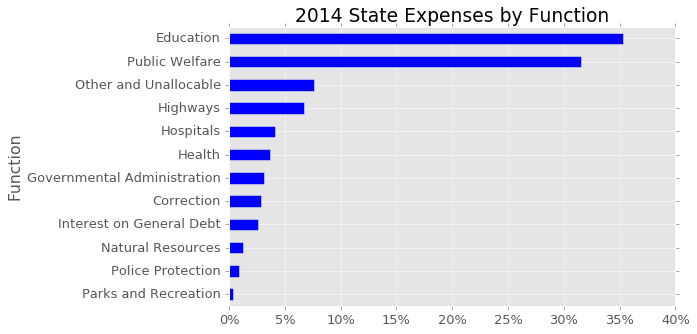

In [166]:
# adjust matplotlib style & font-size
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 13})

# re-sort values, create the plot, and adjust the formatting of the x-axis
df_totals.sort_values(by = 'pct', ascending=True, inplace=True)
ax = df_totals.plot(kind='barh', x='Function', y='pct', figsize=(8,5), legend=False,
                    title='2014 State Expenses by Function')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 

In [167]:
# adding state abbreviations to the dataframe for the country heatmap

import io
import requests
url = 'http://www.fonz.net/blog/wp-content/uploads/2008/04/states.csv'
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')))
c = c[c['State'] != 'District of Columbia']

df = pd.merge(df.copy(), c, how='left', on='State')

In [168]:
# calculate percentage of spend by function for each state
new_cols = []
for col in sum_cols:
    n_col = col + ' %'
    df[n_col] = df[col] / df['Total'] * 100
    df[n_col] = df[n_col].round(decimals=1)
    new_cols.append(n_col)
    
df.head()

Function,State,Correction,Education,Governmental Administration,Health,Highways,Hospitals,Interest on General Debt,Natural Resources,Other and Unallocable,...,Governmental Administration %,Health %,Highways %,Hospitals %,Interest on General Debt %,Natural Resources %,Other and Unallocable %,Parks and Recreation %,Police Protection %,Public Welfare %
0,Alabama,541554,10367010,583739,520967,1684932,2184917,453928,262297,1099257,...,2.4,2.1,6.9,8.9,1.9,1.1,4.5,0.1,0.7,27.0
1,Alaska,335504,2768833,664797,323760,1243655,70127,250410,353554,3066101,...,5.8,2.8,10.9,0.6,2.2,3.1,26.8,0.2,1.4,19.0
2,Arizona,1059088,9714410,695711,2041887,1758371,854563,519164,263324,2806484,...,2.4,7.0,6.0,2.9,1.8,0.9,9.6,0.3,0.8,31.2
3,Arkansas,392988,7610604,631150,305095,1372565,942018,140240,256092,1010680,...,3.4,1.6,7.4,5.1,0.8,1.4,5.4,0.3,0.6,30.8
4,California,8949885,79812818,7973800,8842113,12631699,9822407,7205964,3719571,10167133,...,3.4,3.8,5.4,4.2,3.1,1.6,4.3,0.2,0.7,35.6


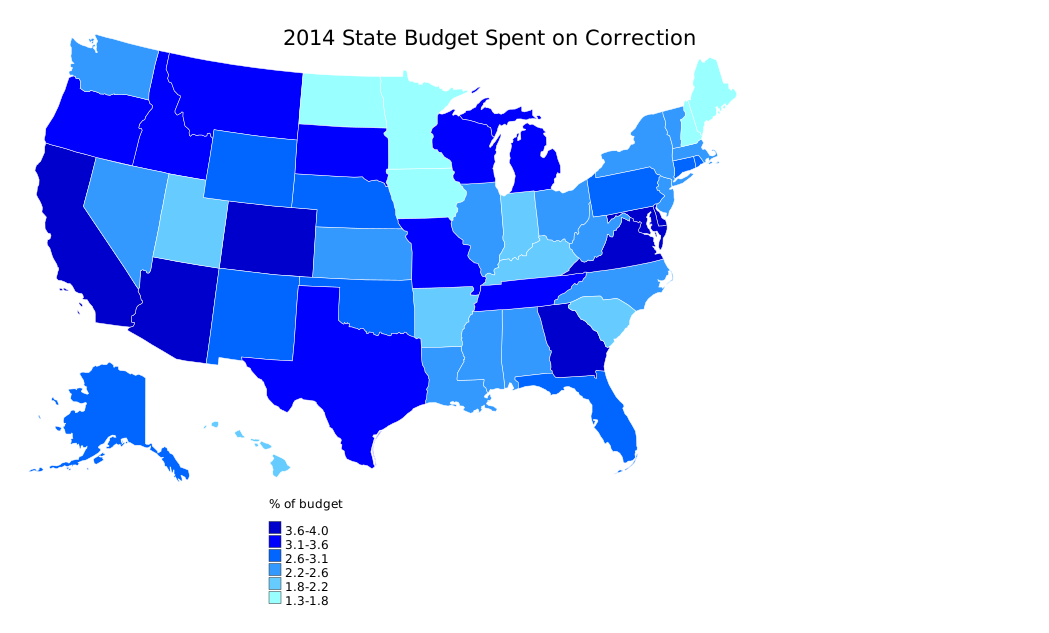

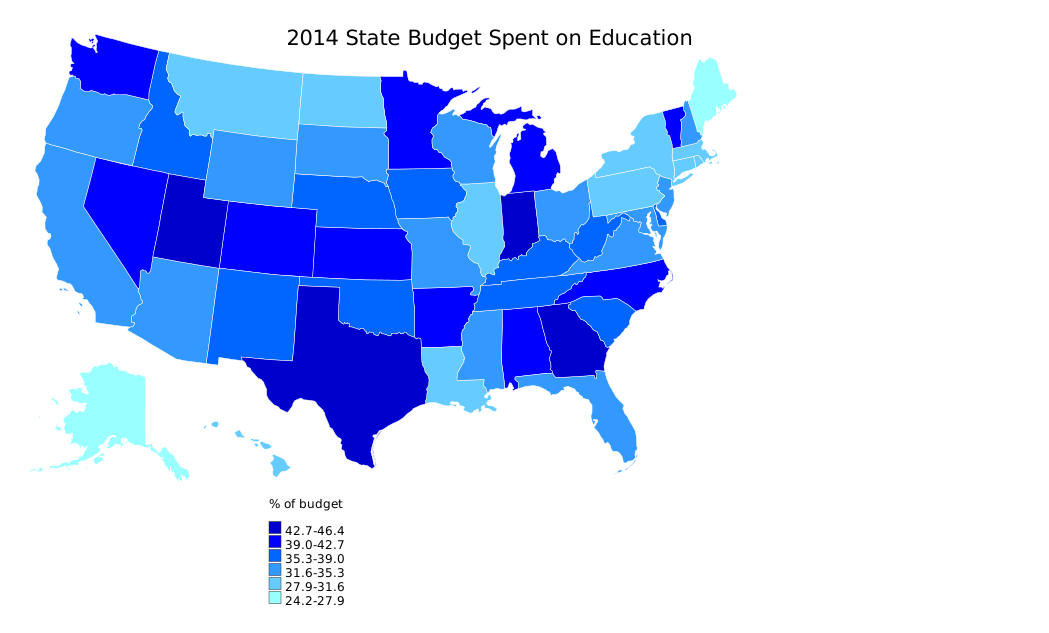

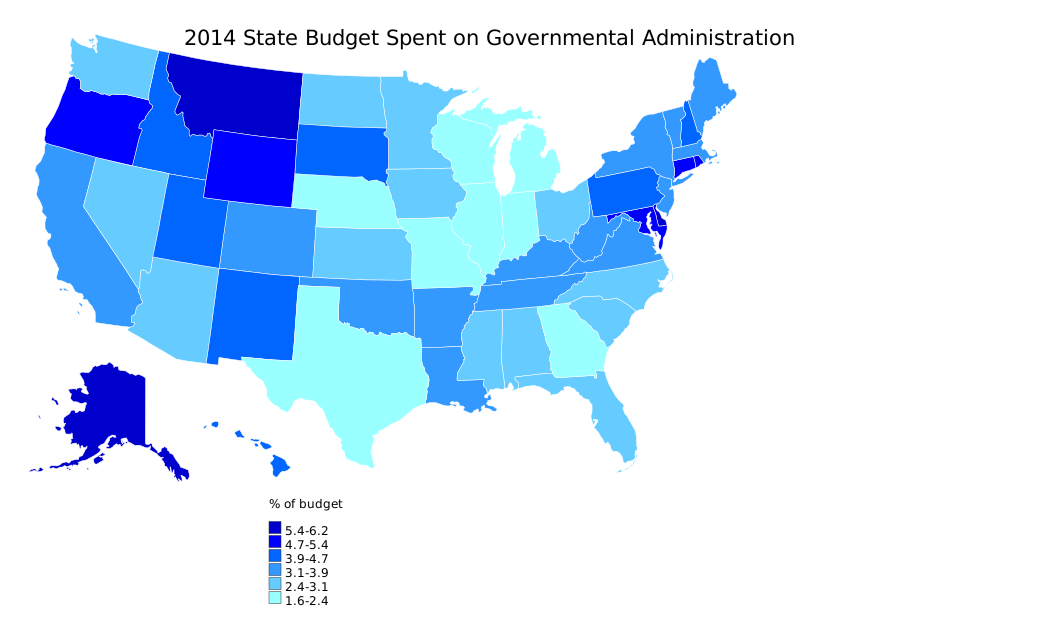

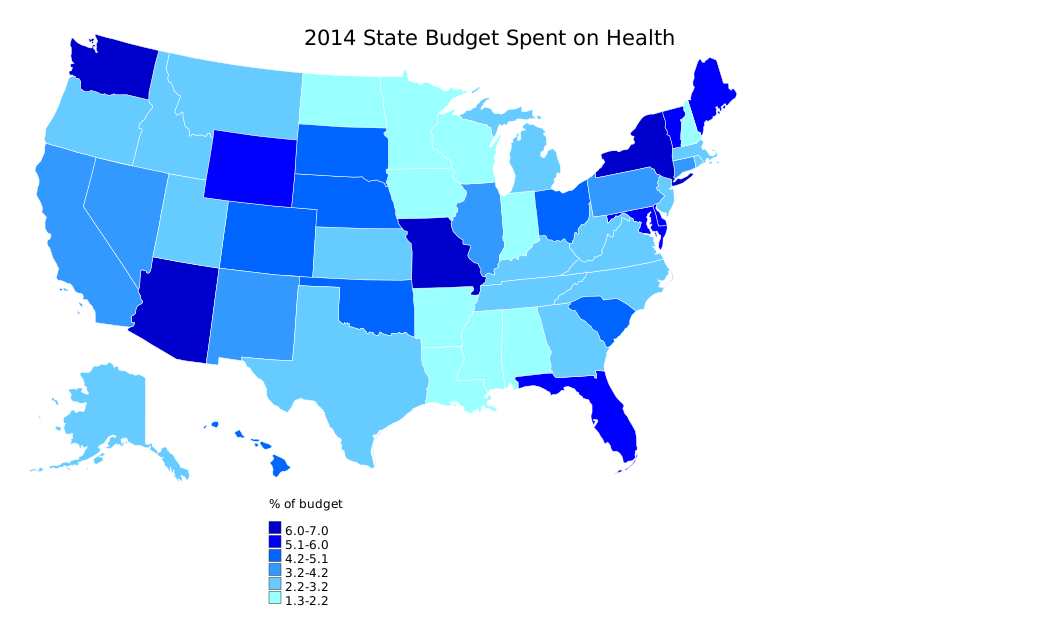

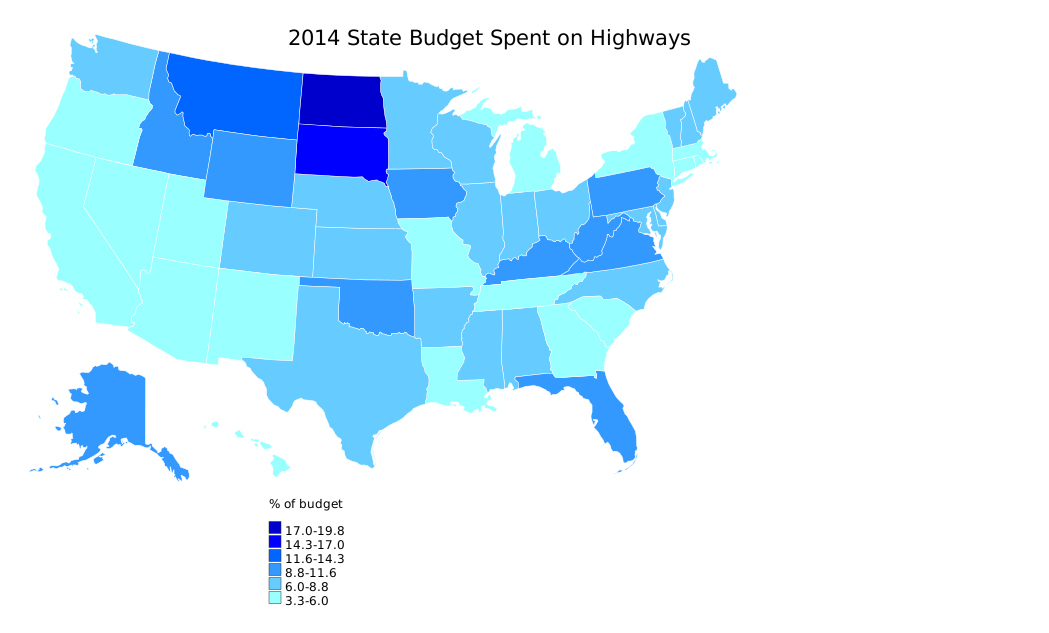

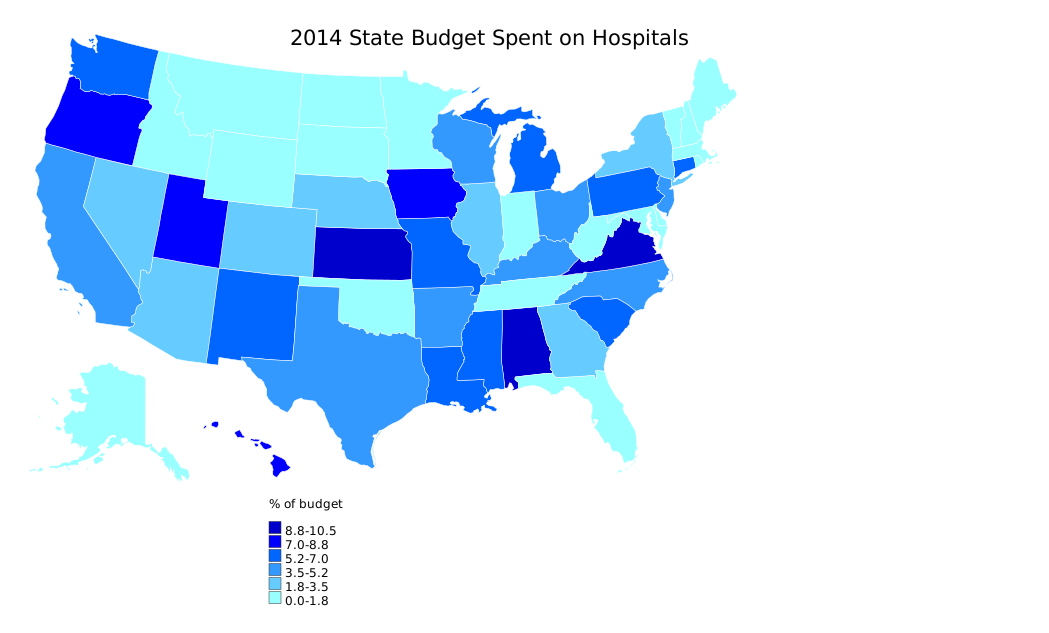

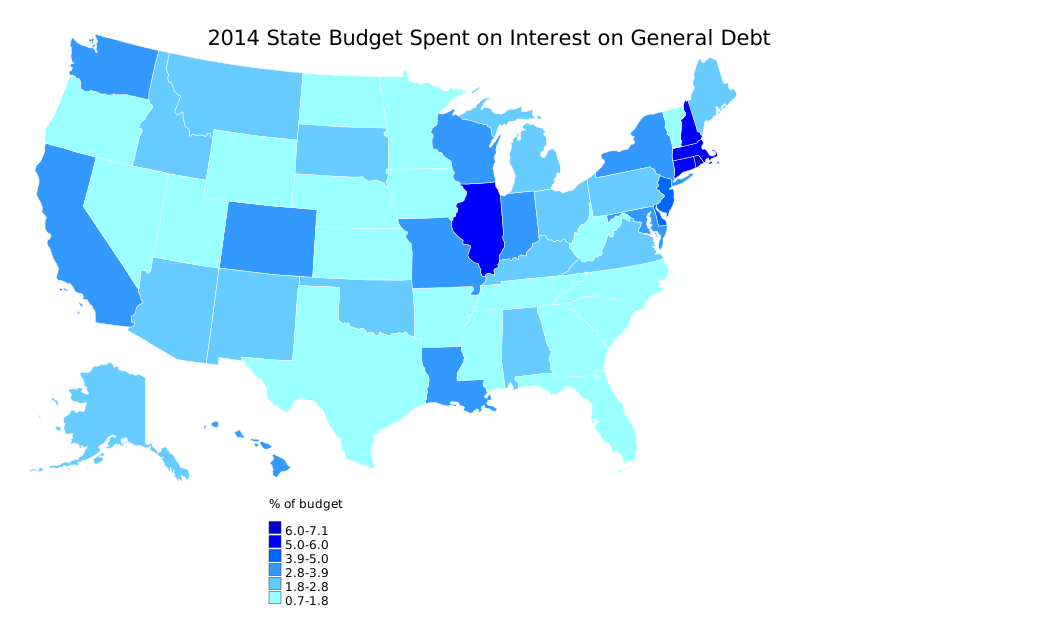

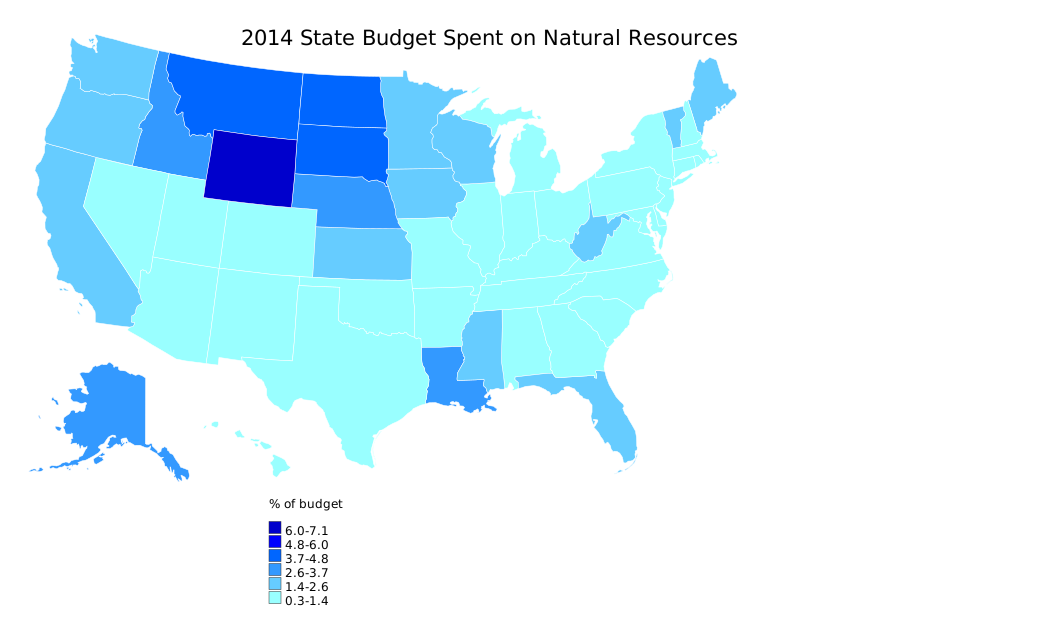

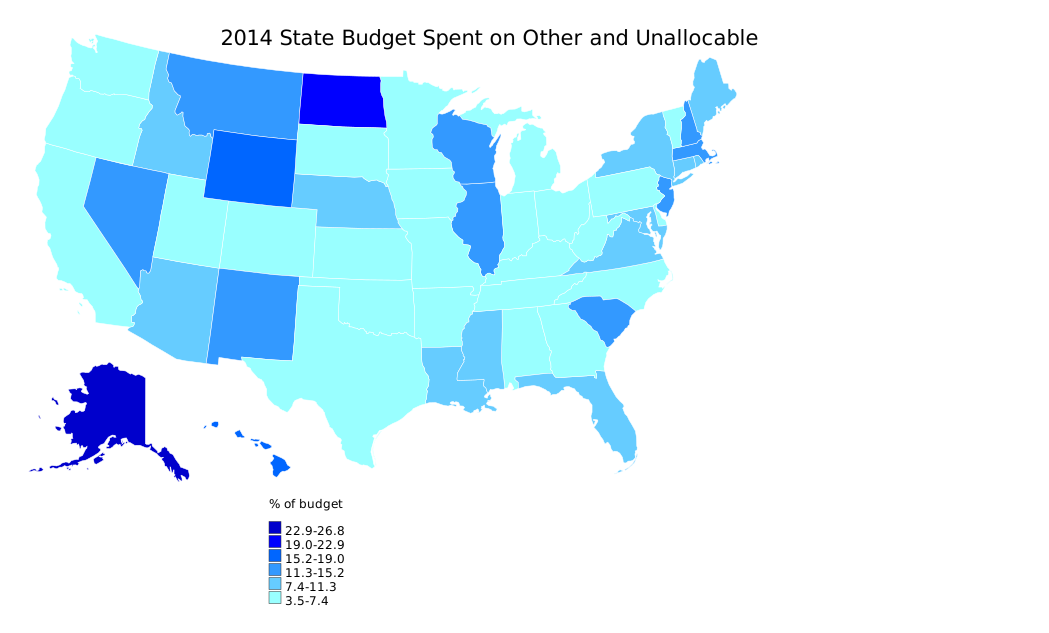

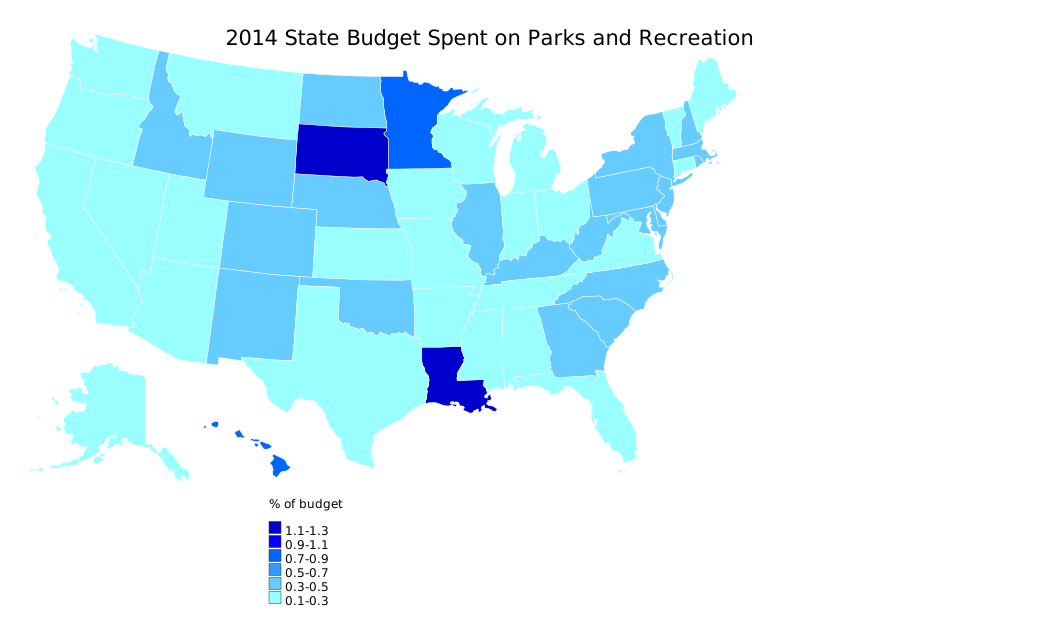

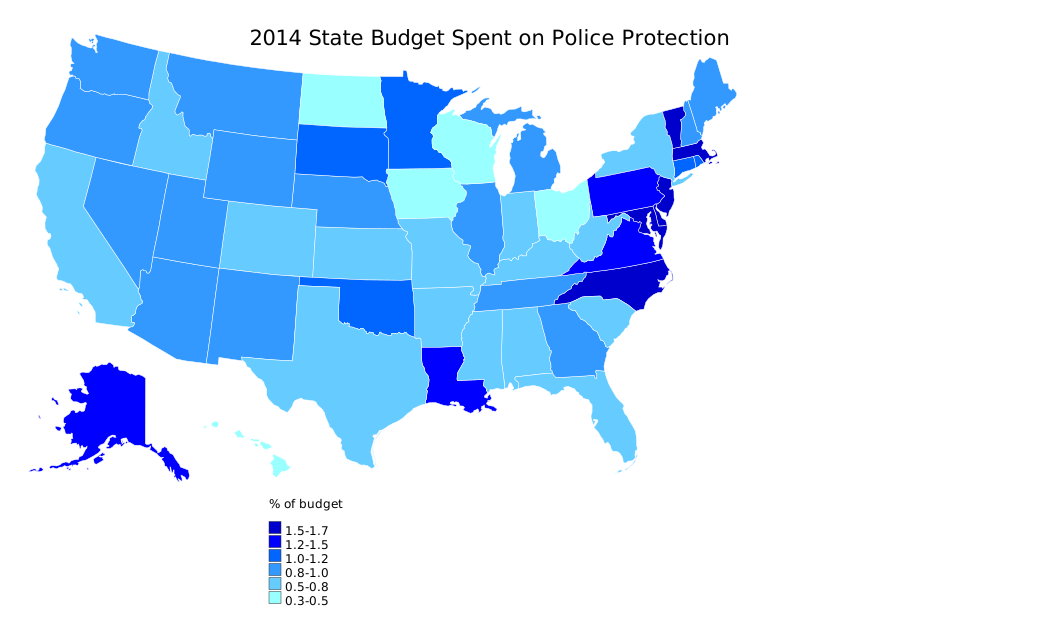

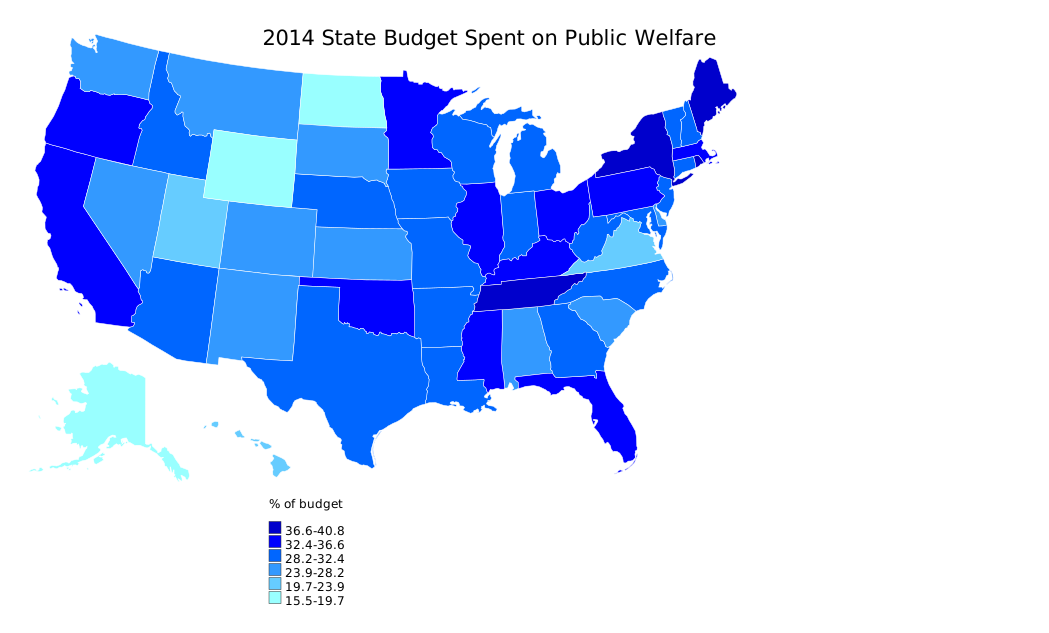

In [181]:
# create heatmap of USA
from chorogrid import Colorbin, Chorogrid

def choro_map(col):
    
    mycolors = ['#99ffff', '#66ccff', '#3399ff', '#0066ff', '#0000ff', '#0000cc']
    mybin = Colorbin(df[col], mycolors, proportional=True, decimals=None)
    mybin.set_decimals(2)

    states = list(df['Abbreviation'])
    colors_by_state = mybin.colors_out
    font_colors_by_state = mybin.complements
    legend_colors = mybin.colors_in
    legend_labels = mybin.labels
    mybin.fenceposts = [round(i,1) for i in mybin.fenceposts]
    mybin.recalc(fenceposts=False)

    st_dir = 'C:/Users/Michael/Anaconda3/Lib/chorogrid/databases/usa_states.csv'
    cg = Chorogrid(st_dir, states, colors_by_state)
    func = col[:-2]
    cg.set_title('2014 State Budget Spent on {0}'.format(func))
    cg.set_legend(mybin.colors_in, mybin.labels, title='% of budget')
    cg.draw_map(spacing_dict={'legend_offset': [-700,-25]})
    
    return cg.done(show=True, save_filename='test')

for col in new_cols:
    choro_map(col)